# FCPG Test Notebook

This notebook facilitates testing the the core functionality of the FCPG tools. This steps through providing input data, converting ESRI flow directions to TauDEM flow direction, resampling and reprojecting input data, generating upstream FCPGs, creating a dictionary to cascade values from upstream to downstream hydrologic units, updating downstream parameter grids, accumulating updated grids, and making FCPGs corrected for an upstream area. The last section verifies the handling of no data values if that is desired by the user.

This notebook reads data from `./test_data` and writes data to `./test_output`. `./test_output` can be discarded after testing is complete.

Input and output grids can be examined in either ArcGIS or QGIS.

In [1]:
import FCPGtools as fc
import os
import rasterio as rs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Verbose output
verbose = True


def plot(fl, cmap='Blues'):
    """
    Helper plotter function.
    """
    src = rs.open(fl)
    tmp = src.read(1)
    try:
        tmp[tmp == src.nodata] = np.NaN
    except Exception:
        pass
    plt.figure(figsize = (10, 10))
    plt.imshow(tmp, cmap = cmap)


print('FCPGtools version %s loaded from %s' % (fc.__version__, fc.__path__[0]))

FCPGtools version 1.0.9 loaded from C:\Users\xrnogueira\Documents\FCPGtools\FCPGtools


In [41]:
# upstream area FDR grid
upstreamFDR = os.path.join('.', 'test_data', 'validation_upstream_fdr.tif')

# downstream area FDR grid
downstreamFDR = os.path.join('.', 'test_data', 'validation_downstream_fdr.tif')

# upstream WBD subset to test cascading parameters
upstreamWBD = gpd.read_file(os.path.join('.', 'test_data/upstream_wbd.shp'))

# parameter datasets
P = os.path.join('.', 'test_data', 'validation_daymet_an_P_2017.tif')  # daymet annual P for 2017
LC = os.path.join('.', 'test_data', 'NALCMS_2015.tif')  # North America Land Cover 2015

testFolder = os.path.join('.', 'test_output')  # folder to store outputs

In [42]:
# reproject the WBD to the grid CRS
tmp = rs.open(upstreamFDR)
dstCRS = tmp.crs.to_proj4()

upstreamWBD.to_crs(crs=dstCRS, inplace=True)

In [4]:
# make test output location if it doesn't exist, this directory can be deleted later
if os.path.exists(testFolder) is False:
    os.mkdir(testFolder)

## Convert ESRI FDR to TauDEM FDR

In [5]:
# define output paths
upstreamFDRTau = os.path.join(testFolder, 'upstreamFDRtau.tif')
downstreamFDRTau = os.path.join(testFolder, 'downstreamFDRtau.tif')

In [6]:
# reclassify ESRI drainage directions to TauDEM
fc.tauDrainDir(upstreamFDR, upstreamFDRTau, verbose=verbose)
fc.tauDrainDir(downstreamFDR, downstreamFDRTau, verbose=verbose)

Reclassifying Flow Directions...
TauDEM drainage direction written to: .\test_output\upstreamFDRtau.tif
Reclassifying Flow Directions...
TauDEM drainage direction written to: .\test_output\downstreamFDRtau.tif


## Resample Daymet and Land Cover

In [7]:
# define output paths
Pupstream = os.path.join(testFolder, 'Pup.tif')
Pdownstream = os.path.join(testFolder, 'Pdwn.tif')
LCupstream = os.path.join(testFolder, 'LCup.tif')
LCdownstream = os.path.join(testFolder, 'LCdwn.tif')

In [48]:
%%timeit
rs.open(r'.\test_output\upstreamFDRtau.tif')

2.82 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
# resample and crop daymet (upstream then downstream)
fc.resampleParam(P, upstreamFDRTau, Pupstream, forceProj=True, verbose=verbose)
fc.resampleParam(P, downstreamFDRTau, Pdownstream, forceProj=True, verbose=verbose)

# resanoke LC raster (upstream then downstream)
fc.resampleParam(LC, upstreamFDRTau, LCupstream, forceProj=True,
                 verbose=verbose, resampleMethod='near')
fc.resampleParam(LC, downstreamFDRTau, LCdownstream, forceProj=True,
                 verbose=verbose, resampleMethod='near')

Flow Direction Proj4: "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
Parameter Proj4:+proj=lcc +lat_0=42.5 +lon_0=-100 +lat_1=25 +lat_2=60 +x_0=0 +y_0=0 +a=6378137 +rf=298.25723 +units=m +no_defs=True
Flow Direction Xsize:30.0
Parameter Xsize:1000.0
FDR Lower Right Corner: -1354064.9999999995, 1635194.9999999963
FDR Upper Left Corner: -1384004.9999999995, 1666364.9999999963
Param Lower Right Corner: -971750.0, -542500.0
Param Upper Left: -1002750.0, -511500.0
Resampling and Reprojecting Parameter Raster...
gdalwarp -overwrite -tr 30.0 30.0 -t_srs "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs" -te -1384004.9999999995 1635194.9999999963 -1354064.9999999995 1666364.9999999963 -co "PROFILE=GeoTIFF" -co "TILED=YES" -co "SPARSE_OK=TRUE" -co "COMPRESS=LZW" -co "ZLEVEL=9" -co "NUM_THREADS=1" -co "BIGTIFF=IF_SAFER" -r bilinear -dstnodata -999.0 -ot Float32 .\te

## Binarize Land Cover

In [9]:
usLCbinary = fc.cat2bin(LCupstream, testFolder, verbose=verbose)
dsLCbinary = fc.cat2bin(LCdownstream, testFolder, verbose=verbose)

Creating binaries for .\test_output\LCup.tif
Creating binaries for .\test_output\LCdwn.tif


## Accumulate the Upstream Area

In [10]:
# create path for, and the output for, a FAC grid
upstreamFAC = os.path.join(testFolder, 'upstreamFAC.tif')

fc.tauFlowAccum(upstreamFDRTau, upstreamFAC, cores=4, verbose=verbose)

Accumulating Data...
mpiexec -n 4 aread8 -p .\test_output\upstreamFDRtau.tif -ad8 .\test_output\upstreamFAC.tif -nc


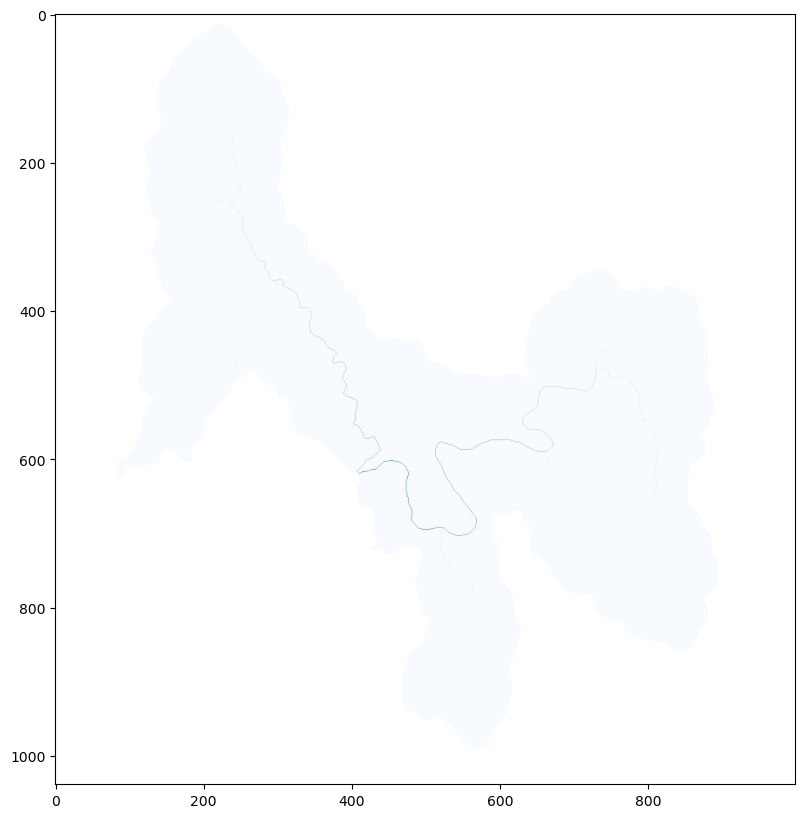

In [11]:
plot(upstreamFAC)

## Demonstration of Multiple Pour Points

The following is a demonstration of the workflow for HUC4 geospatial tiles (NHD High-Res). The update dictionary produced here is not used after this Section.

In [43]:
upstreamWBD

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,NonContrib,NonContr_1,AreaSqKm,...,GNIS_ID,Name,States,HUC12,HUType,HUMod,ToHUC,Shape_Leng,Shape_Area,geometry
0,2685,{AAAE4745-7F69-4249-9EE6-61A0FDD375D2},{2E2678AC-0C9D-49CB-806B-540A9302D247},None,None,None,2013-01-18,0.0,0.0,133.04,...,0,Honey Draw-Colorado River,AZ,140700061105,S,DM,150100010303,0.805006,0.013444,"POLYGON ((-1357947.568 1651035.025, -1357949.2..."
1,2737,{6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB},{AEC557FF-82D8-4F4D-BF0D-2BF431714390},None,None,None,2017-10-25,0.0,0.0,90.55,...,0,Johnson Point-Paria River,"AZ,UT",140700070706,S,NM,150100010303,0.612730,0.009157,"POLYGON ((-1377191.806 1665386.803, -1377192.3..."


In [12]:
# get up- and  down- stream HUC4 basins IDs (HUC4 and ToHUC4 are the new columns)
pourBasins = fc.makePourBasins(upstreamWBD, '1407', '1501')
pourBasins.head(n=2)

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,NonContrib,NonContr_1,AreaSqKm,...,States,HUC12,HUType,HUMod,ToHUC,Shape_Leng,Shape_Area,geometry,HUC4,ToHUC4
0,2685,{AAAE4745-7F69-4249-9EE6-61A0FDD375D2},{2E2678AC-0C9D-49CB-806B-540A9302D247},None,None,None,2013-01-18,0.0,0.0,133.04,...,AZ,140700061105,S,DM,150100010303,0.805006,0.013444,"POLYGON ((-1357947.568 1651035.025, -1357949.2...",1407,1501
1,2737,{6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB},{AEC557FF-82D8-4F4D-BF0D-2BF431714390},None,None,None,2017-10-25,0.0,0.0,90.55,...,"AZ,UT",140700070706,S,NM,150100010303,0.612730,0.009157,"POLYGON ((-1377191.806 1665386.803, -1377192.3...",1407,1501


N=2 were found with the following XYZ coorindates: 
[(-1370669.9999999995, 1648259.9999999963, 155007.0), (-1371809.9999999995, 1647779.9999999963, 101615.0)]


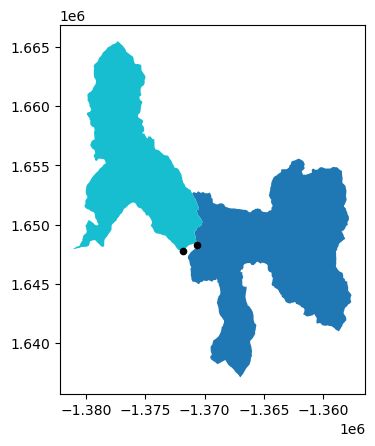

In [14]:
# find pourpoints using the basin shapefile, FAC, and TauDEM FDR.
pourPts = fc.findPourPoints(pourBasins, upstreamFAC, upstreamFDRTau, plotBasins=True)
print(f'N={len(pourPts)} were found with the following XYZ coorindates: \n{pourPts}')

In [15]:
# create an initial dictionary for the region 14 to 15 cascade
updateDictFl = os.path.join(testFolder, 'HUC1407_update.json')
upHUC = '1407'

# expand the pour points
x, y, w = zip(*pourPts)
ud = fc.createUpdateDict(x, y, w, upHUC, updateDictFl, verbose=verbose)

In [16]:
ud  # there are two pour points

{'1407': {'x': ['-1370669.9999999995', '-1371809.9999999995'],
  'y': ['1648259.9999999963', '1647779.9999999963'],
  'maxUpstreamFAC': ['155007.0', '101615.0'],
  'vars': ['maxUpstreamFAC']}}

## Find Pour Point to Downstream Area
Here we find the single pour point between region 14 and region 15.

In [44]:
# locate max FAC value
x, y, d, w = fc.findLastFACFD(upstreamFAC, fl=upstreamFAC)

# Get flow direction of above point
x, y, f, w = fc.findLastFACFD(upstreamFAC, fl=upstreamFDRTau)
print(x, y, d, w)

-1371809.9999999995 1647749.9999999963 257922.0 30.0


In [45]:
# create an initial dictionary for the region 14 to 15 cascade
updateDictFl = os.path.join(testFolder, 'HUC14_update.json')
upHUC = '14'
ud = fc.createUpdateDict([x], [y], [d], upHUC, updateDictFl, verbose=verbose)
print(ud)

{'14': {'x': ['-1371809.9999999995'], 'y': ['1647749.9999999963'], 'maxUpstreamFAC': ['257922.0'], 'vars': ['maxUpstreamFAC']}}


## FCPG Upstream Daymet and Land Cover

In [19]:
# append the Daymet path to the land cover binary grids
usLCbinary.append(Pupstream)

In [20]:
accumParams = fc.accumulateParam_batch(usLCbinary, upstreamFDRTau, testFolder,
                                       cores=4, verbose=verbose)

In [21]:
upstream_cpgs = fc.make_fcpg_batch(accumParams, upstreamFAC, testFolder, verbose=verbose)

Reading accumulated parameter file 2022-09-08 10:26:33.748948
Reading basin flow accumulation file 2022-09-08 10:26:33.775948
Number of zero values:2
Computing CPG values 2022-09-08 10:26:33.929948
Replacing numpy nan values 2022-09-08 10:26:33.931946
Saving CPG raster 2022-09-08 10:26:33.998946
CPG file written to: .\test_output\LCup0accumFCPG.tif
Reading accumulated parameter file 2022-09-08 10:26:34.019946
Reading basin flow accumulation file 2022-09-08 10:26:34.040947
Number of zero values:2
Computing CPG values 2022-09-08 10:26:34.188950
Replacing numpy nan values 2022-09-08 10:26:34.190966
Saving CPG raster 2022-09-08 10:26:34.246948
CPG file written to: .\test_output\LCup1accumFCPG.tif
Reading accumulated parameter file 2022-09-08 10:26:34.269951
Reading basin flow accumulation file 2022-09-08 10:26:34.294948
Number of zero values:2
Computing CPG values 2022-09-08 10:26:34.451946
Replacing numpy nan values 2022-09-08 10:26:34.453948
Saving CPG raster 2022-09-08 10:26:34.518948
C

### Create Update Dictionary with FCPG Values

In [22]:
# Update the dictionary with values from the upstream accumulated parameters, this should probably be a v2 function...
for fl in accumParams:  # iterate through the accumulated parameters
    print(fl)
    # Parse the file names into variable names...
    varname = fl.split('/')[-1].split('up')[0]
    if varname == 'LC':
        mod = fl.split('/')[-1].split('up')[-1].split('accum')[0]
        var = varname+mod
    else:
        var = varname

    # Query accumualted raster for values
    val = str(fc.queryPoint(x, y, fl))
    ud = fc.updateDict(updateDictFl, '14', var, [val])

.\test_output\LCup0accum.tif
.\test_output\LCup1accum.tif
.\test_output\LCup7accum.tif
.\test_output\LCup8accum.tif
.\test_output\LCup9accum.tif
.\test_output\LCup10accum.tif
.\test_output\LCup14accum.tif
.\test_output\LCup15accum.tif
.\test_output\LCup16accum.tif
.\test_output\LCup17accum.tif
.\test_output\LCup18accum.tif
.\test_output\Pupaccum.tif


## Cascade to Downstream Area

In [23]:
downstreamFACadj = os.path.join(testFolder, 'downstreamFACadj.tif')
downstreamFACweight = os.path.join(testFolder, 'downstreamFACweight.tif')
fc.adjustFAC(downstreamFDRTau, downstreamFACweight, updateDictFl, downstreamFDRTau,
             downstreamFACadj, cores=4, verbose=verbose)

Updating FAC weighting grid with value from 14 FAC


In [24]:
dsLCbinary.append(Pdownstream) #add the precip into the downstream land cover files

In [25]:
# create updated, unaccumulated parameter grids for the downstream region
adjDSparams = []

# iterate through the accumulated parameters
for fl, inGrid in zip(accumParams, dsLCbinary):
    # Parse the file names into variable names...
    varname = fl.split('/')[-1].split('up')[0]
    if varname == 'LC':
        mod = fl.split('/')[-1].split('up')[-1].split('accum')[0]
        var = varname+mod
    else:
        var = varname

    outfl = inGrid.split('.tif')[0]+'adj.tif'

    fc.adjustParam(var, inGrid, updateDictFl, outfl, verbose=verbose)
    adjDSparams.append(outfl)

Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC


In [26]:
# accumulate the downstream parameter grids
DSaccum = fc.accumulateParam_batch(adjDSparams, downstreamFDRTau, testFolder,
                                   cores=4, verbose=verbose)

In [27]:
# accumulate the downstream area
dsFCPG = fc.make_fcpg_batch(DSaccum, downstreamFACadj, testFolder, verbose=verbose)

Reading accumulated parameter file 2022-09-08 10:26:43.828995
Reading basin flow accumulation file 2022-09-08 10:26:43.847996
Number of zero values:2
Computing CPG values 2022-09-08 10:26:44.018993
Replacing numpy nan values 2022-09-08 10:26:44.019994
Saving CPG raster 2022-09-08 10:26:44.090994
CPG file written to: .\test_output\LCdwn0adjaccumFCPG.tif
Reading accumulated parameter file 2022-09-08 10:26:44.109994
Reading basin flow accumulation file 2022-09-08 10:26:44.126998
Number of zero values:2
Computing CPG values 2022-09-08 10:26:44.276992
Replacing numpy nan values 2022-09-08 10:26:44.277996
Saving CPG raster 2022-09-08 10:26:44.351001
CPG file written to: .\test_output\LCdwn1adjaccumFCPG.tif
Reading accumulated parameter file 2022-09-08 10:26:44.373993
Reading basin flow accumulation file 2022-09-08 10:26:44.389993
Number of zero values:2
Computing CPG values 2022-09-08 10:26:44.550994
Replacing numpy nan values 2022-09-08 10:26:44.550994
Saving CPG raster 2022-09-08 10:26:44.

## Insert NoData values into Daymet and Verify FCPG NoData Behavior 

In [28]:
with rs.open(upstreamFDR) as src:
    fdr = src.read(1)
    fdr[fdr == src.nodata] = 0
    fdr[fdr != 0] = 1
    mask = fdr.astype(np.uint)

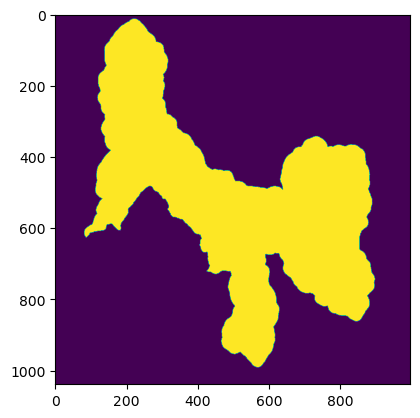

In [29]:
plt.imshow(mask)

In [30]:
# make row,col vectors of where to insert nodata values
size = 1000  # number of no data values to insert

# get locations of all points within the watershed
idCol, idRow = np.where(mask == 1)
cols = np.random.choice(idCol, size=size, replace=False)
rows = np.random.choice(idRow, size=size, replace=False)

In [31]:
# output file name
PupstreamNoData = os.path.join(testFolder, 'PupNoData.tif')

# open source
with rs.open(Pupstream) as src:
    meta = src.meta
    noData = src.nodata
    P = src.read(1)

P[cols, rows] = noData  # insert nodata values

# write out updated P grid
with rs.open(PupstreamNoData, 'w', **meta) as dst:
    dst.write(P, 1)

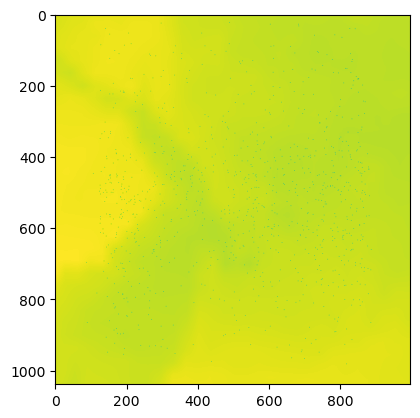

In [32]:
plt.imshow(P)

In [33]:
# accumualte the P raster with no data values added and produce the noData grids

accumRast = os.path.join(testFolder, 'PupNoData_accum.tif')
outNoDataAccum = os.path.join(testFolder, 'PupNoData_accumNoData.tif')
outNoData = os.path.join(testFolder, 'PupNodataRast.tif')
outNoDataZero = os.path.join(testFolder, 'PupNoDataZero.tif')

fc.accumulateParam(PupstreamNoData, upstreamFDRTau, accumRast,
                   outNoDataRast = outNoData, outNoDataAccum=outNoDataAccum,
                   zeroNoDataRast = outNoDataZero, cores=4, verbose=verbose)

Parameter Zero No Data raster written to: .\test_output\PupNoDataZero.tif
Parameter No Data raster written to: .\test_output\PupNodataRast.tif
Accumulating No Data Values
mpiexec -n 4 aread8 -p .\test_output\upstreamFDRtau.tif -ad8 .\test_output\PupNoData_accumNoData.tif -wg .\test_output\PupNodataRast.tif -nc
Parameter no data accumulation written to: .\test_output\PupNodataRast.tif
Accumulating Data...
mpiexec -n 4 aread8 -p .\test_output\upstreamFDRtau.tif -ad8 .\test_output\PupNoData_accum.tif -wg .\test_output\PupNoDataZero.tif -nc


In [34]:
# make a FCPG accounting for noData
outRast = os.path.join(testFolder, 'Pup_FCPG_noData.tif')

fc.make_fcpg(accumRast, upstreamFAC, outRast, noDataRast=outNoDataAccum, verbose=verbose)

Reading accumulated parameter file 2022-09-08 10:26:48.718775
Reading basin flow accumulation file 2022-09-08 10:26:48.756775
Correcting CPG for no data values
Number of zero values:2
Computing CPG values 2022-09-08 10:26:48.895774
Replacing numpy nan values 2022-09-08 10:26:48.897775
Saving CPG raster 2022-09-08 10:26:48.970775
CPG file written to: .\test_output\Pup_FCPG_noData.tif


## Decay FCPG

Produce a FCPG where values are decayed based on their distance to a stream, this can be useful for producing FCPGs with more localized values rather than basin-average values.

In [35]:
# D-infinity flow direction raster
upstreamFDRTauDinf = os.path.join(testFolder, 'upstreamFDRDinf.tif')

# convert D8 flow directions to D-inf flow directions
fc.d8todinfinity(upstreamFDRTau, upstreamFDRTauDinf, verbose = verbose)

Reclassifying Flow Directions...
TauDEM drainage direction written to: .\test_output\upstreamFDRDinf.tif


In [36]:
streamDistRast = os.path.join(testFolder, 'upstreamDist2Stream.tif')  # distance to stream raster
streamRast = os.path.join(testFolder, 'upstreamSTR900.tif')  # stream raster
fc.makeStreams(upstreamFAC, streamRast, verbose = verbose)

# compute distance to streams, use 900 cells as accumulation threshold
fc.dist2stream(upstreamFDRTau, upstreamFAC, 900, streamDistRast, cores = 4, verbose = verbose)

Loading fac
{'driver': 'GTiff', 'dtype': 'int8', 'nodata': 99, 'width': 998, 'height': 1039, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, -1384004.9999999995,
       0.0, -30.0, 1666364.9999999963), 'tiled': True, 'compress': 'LZW', 'interleave': 'band', 'zlevel': 9, 'profile': 'GeoTIFF', 'sparse_ok': True, 'num_threads': 'ALL_CPUS', 'bigtiff': 'IF_SAFER'}
mpiexec -n

Building decay grid 2022-09-08 10:26:49.729776
Saving decay raster 2022-09-08 10:26:49.742780
Decay raster written to: .\test_output\upstreamDecay.tif


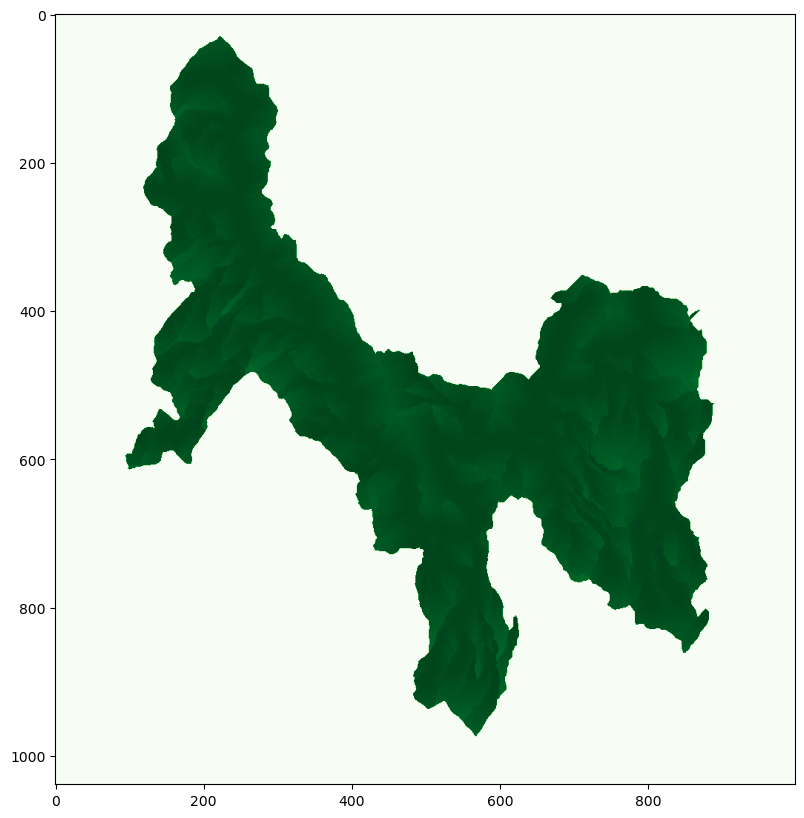

In [37]:
decayRast = os.path.join(testFolder, 'upstreamDecay.tif')
k = 4  # decay coefficient
fc.makeDecayGrid(streamDistRast, k, decayRast, verbose = verbose)
plot(decayRast, cmap = 'Greens')

In [38]:
decayFAC = os.path.join(testFolder, 'decayAccum.tif')  # decay accumulation grid
decayParam = os.path.join(testFolder, 'decayP.tif')  # decay parameter accumulation grid

# perform the parameter decay accumulation
fc.decayAccum(upstreamFDRTauDinf, decayRast, decayParam,  
              paramRast = Pupstream, cores = 4, verbose = verbose)

Accumulating parameter
mpiexec -n 4 dinfdecayaccum -ang .\test_output\upstreamFDRDinf.tif -dm .\test_output\upstreamDecay.tif -dsca .\test_output\decayP.tif, -wg .\test_output\Pup.tif -nc
Parameter accumulation written to: .\test_output\decayP.tif


In [39]:
decayFCPG = os.path.join(testFolder, 'decayFCPG.tif')

# Mask out pixels not on streamlines
fc.maskStreams(decayParam, streamRast, decayFCPG, verbose = verbose)  

Saving raster 2022-09-08 10:26:51.423774


CPLE_AppDefinedError: Deleting .\test_output\decayFCPG.tif failed: Permission denied